In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline

# Set the default plot aesthetics to be prettier.
sns.set_style("darkgrid")

In [2]:
# Weather data from 2014 – mid November 2018
nyc_weather = pd.read_csv("1557522.csv")

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (10,11,14,15,20,23,25,26,28,29,33,34,40,67,84,85,86,87) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
nyc_daily = nyc_weather[['DATE', 'DAILYAverageDryBulbTemp', 'DAILYDeptFromNormalAverageTemp',
                      'DAILYAverageRelativeHumidity', 'DAILYAverageDewPointTemp', 'DAILYHeatingDegreeDays',
                      'DAILYCoolingDegreeDays', 'DAILYPrecip', 'DAILYAverageStationPressure',
                      'DAILYAverageWindSpeed', 'DAILYAverageWetBulbTemp']]

nyc_daily = nyc_daily.dropna()
nyc_daily.head()

,DATE,DAILYAverageDryBulbTemp,DAILYDeptFromNormalAverageTemp,DAILYAverageRelativeHumidity,DAILYAverageDewPointTemp,DAILYHeatingDegreeDays,DAILYCoolingDegreeDays,DAILYPrecip,DAILYAverageStationPressure,DAILYAverageWindSpeed,DAILYAverageWetBulbTemp
25,2014-01-01 23:59,29,-4.4,51.0,13.0,36,0,0.00,30.18,5.6,24.0
59,2014-01-02 23:59,26,-7.3,76.0,19.0,39,0,0.33,29.86,12.2,24.0
97,2014-01-03 23:59,14,-19.1,59.0,1.0,51,0,0.29,29.84,10.4,11.0
123,2014-01-04 23:59,19,-14,48.0,2.0,46,0,0.00,30.28,4.8,15.0
176,2014-01-05 23:59,34,1.1,82.0,28.0,31,0,0.14,30.05,3.7,31.0


In [13]:
nyc_daily['DATE'] = pd.to_datetime(nyc_daily['DATE'])

nyc_daily['DAILYAverageDryBulbTemp'] = pd.to_numeric(nyc_daily['DAILYAverageDryBulbTemp'], errors='coerce')
nyc_daily['DAILYDeptFromNormalAverageTemp'] = pd.to_numeric(nyc_daily['DAILYDeptFromNormalAverageTemp'], errors='coerce')
nyc_daily['DAILYHeatingDegreeDays'] = pd.to_numeric(nyc_daily['DAILYHeatingDegreeDays'], errors='coerce')
nyc_daily['DAILYCoolingDegreeDays'] = pd.to_numeric(nyc_daily['DAILYCoolingDegreeDays'], errors='coerce')
nyc_daily['DAILYPrecip'] = pd.to_numeric(nyc_daily['DAILYPrecip'], errors='coerce')

nyc_daily.dtypes

DATE                              datetime64[ns]
DAILYAverageDryBulbTemp                  float64
DAILYDeptFromNormalAverageTemp           float64
DAILYAverageRelativeHumidity             float64
DAILYAverageDewPointTemp                 float64
DAILYHeatingDegreeDays                   float64
DAILYCoolingDegreeDays                   float64
DAILYPrecip                              float64
DAILYAverageStationPressure              float64
DAILYAverageWindSpeed                    float64
DAILYAverageWetBulbTemp                  float64
dtype: object

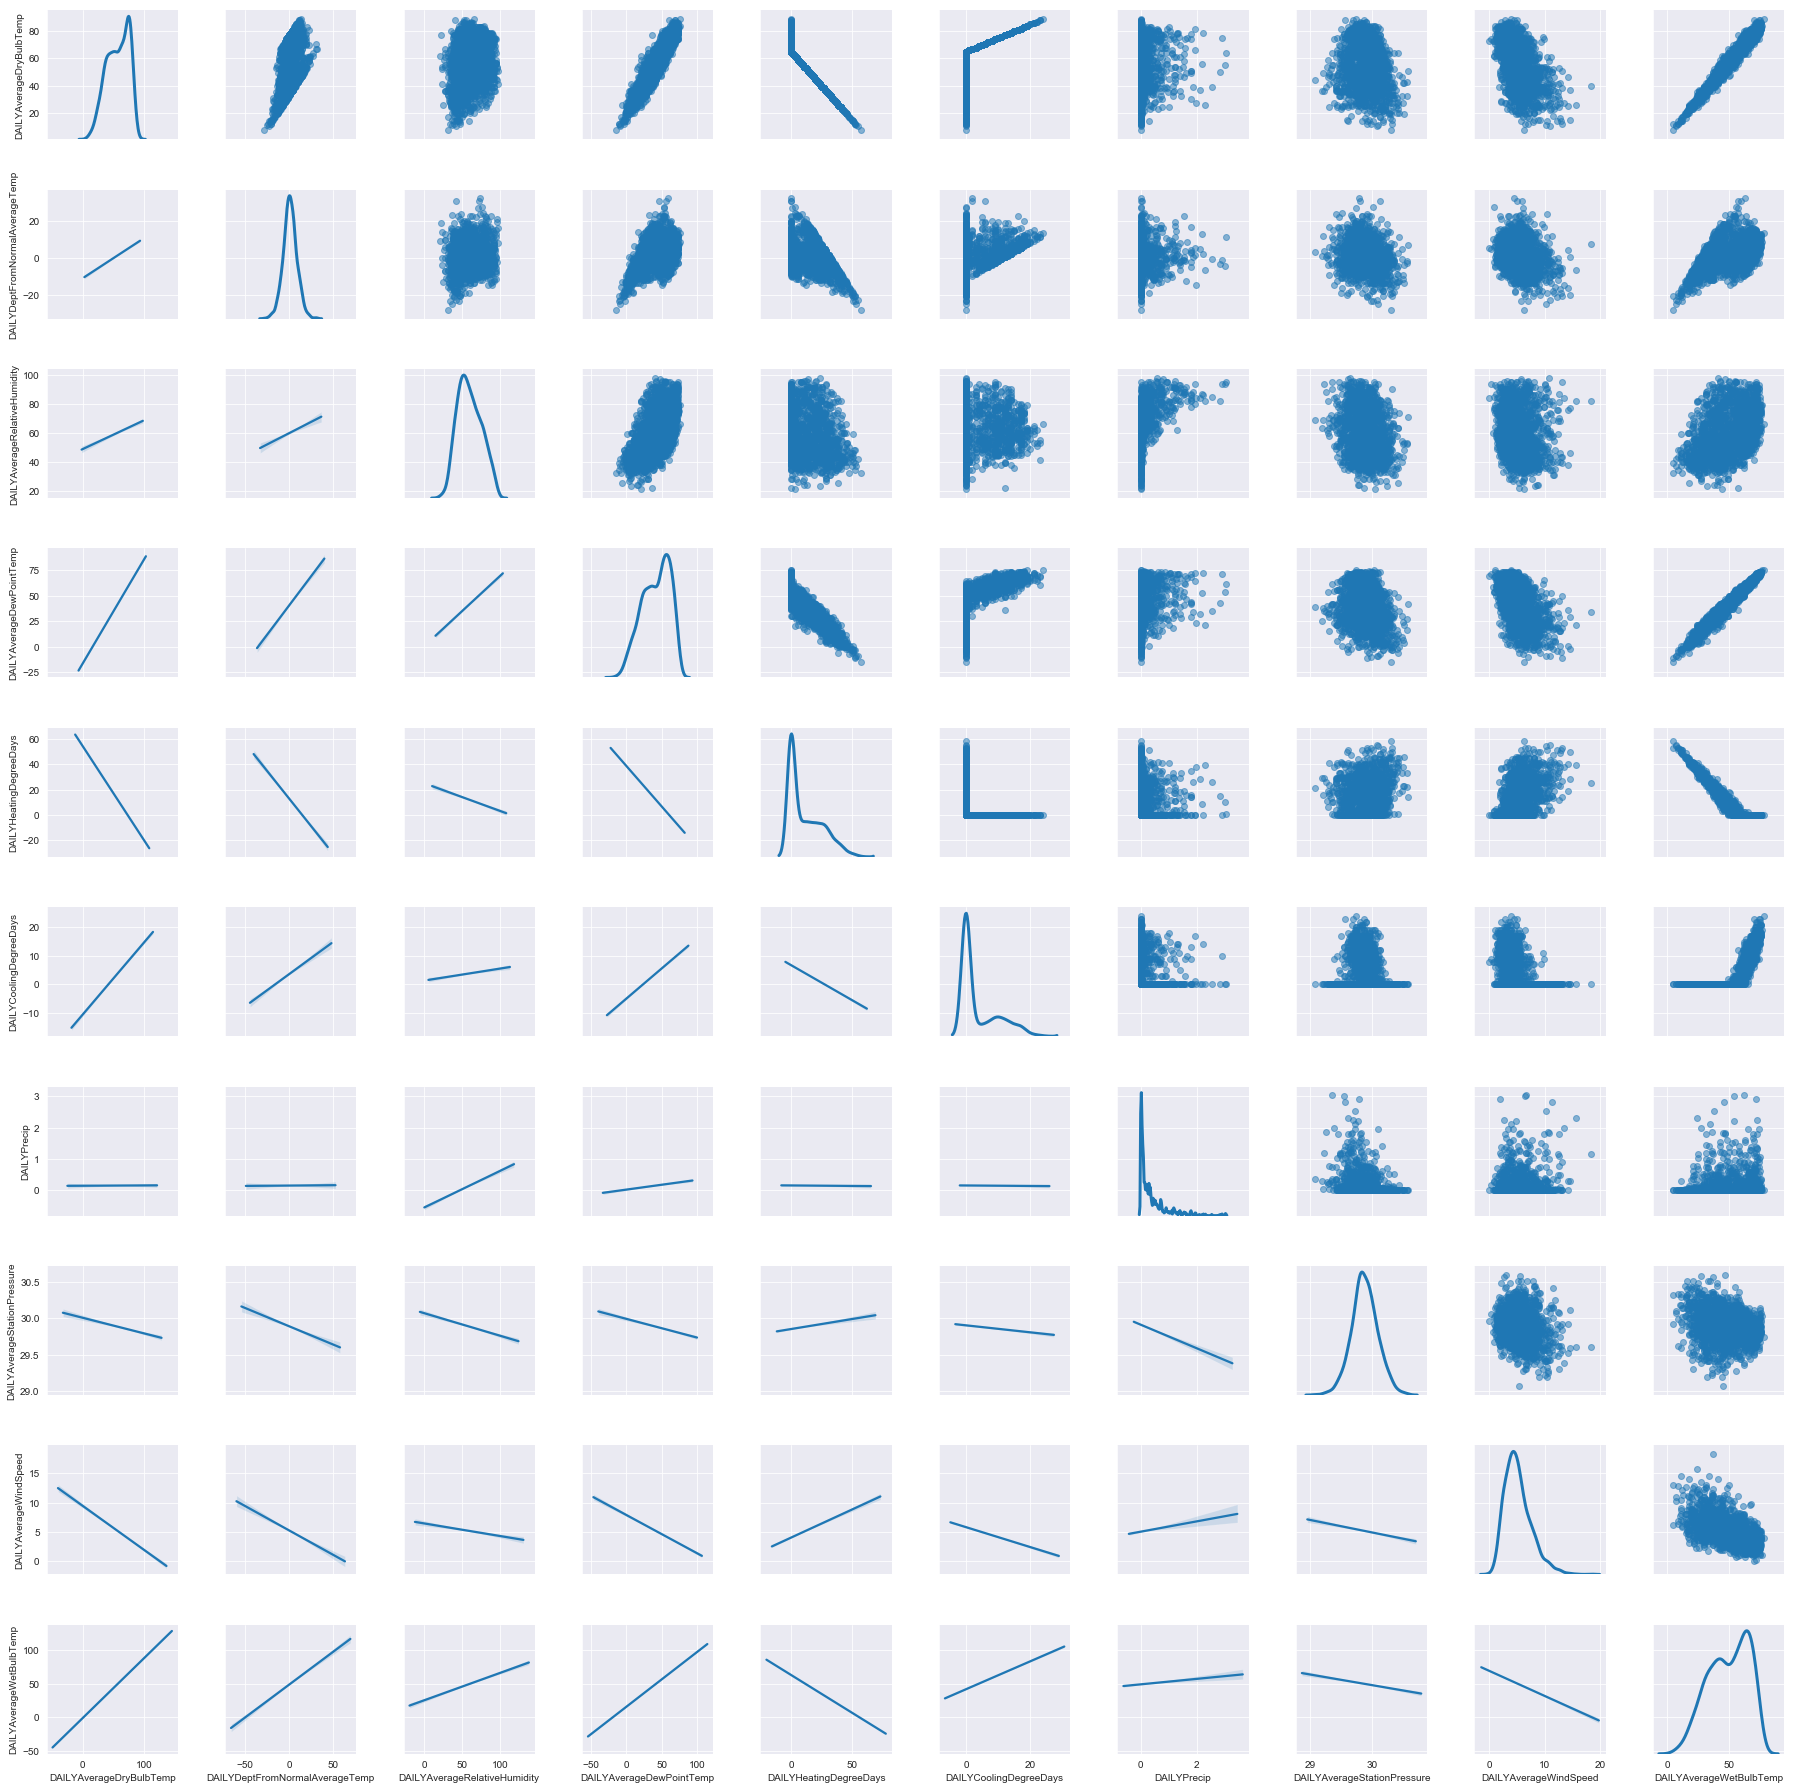

In [14]:
g = sns.PairGrid(nyc_daily, diag_sharey=False)
g.map_upper(plt.scatter, alpha=0.5)
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
g.map_diag(sns.kdeplot, lw=3)

In [28]:
# Month:
nyc_daily['MONTH'] = pd.DatetimeIndex(nyc_daily['DATE']).month

nyc_daily = nyc_daily[['DATE', 'MONTH', 'DAILYAverageDryBulbTemp', 'DAILYAverageWetBulbTemp', 'DAILYDeptFromNormalAverageTemp',
                      'DAILYAverageRelativeHumidity', 'DAILYAverageDewPointTemp', 'DAILYHeatingDegreeDays',
                      'DAILYCoolingDegreeDays', 'DAILYPrecip', 'DAILYAverageStationPressure',
                      'DAILYAverageWindSpeed']].dropna()

In [30]:
# Hot Humidity
nyc_daily["HOT_HUMIDITY"] = nyc_daily['DAILYAverageDryBulbTemp'] * nyc_daily['DAILYAverageDewPointTemp']

In [38]:
nyc_daily['HISTORICALAverageTemp'] = nyc_daily['DAILYAverageDryBulbTemp'] - nyc_daily['DAILYDeptFromNormalAverageTemp']

In [40]:
# Pull out the season from the month

def season(month):
    if month < 4:
        return 1
    elif month >= 4 & month > 7:
        return 2
    elif month >= 7 & month > 10:
        return 3
    else:
        return 4

nyc_daily['SEASON'] = list(map(season, nyc_daily['MONTH']))

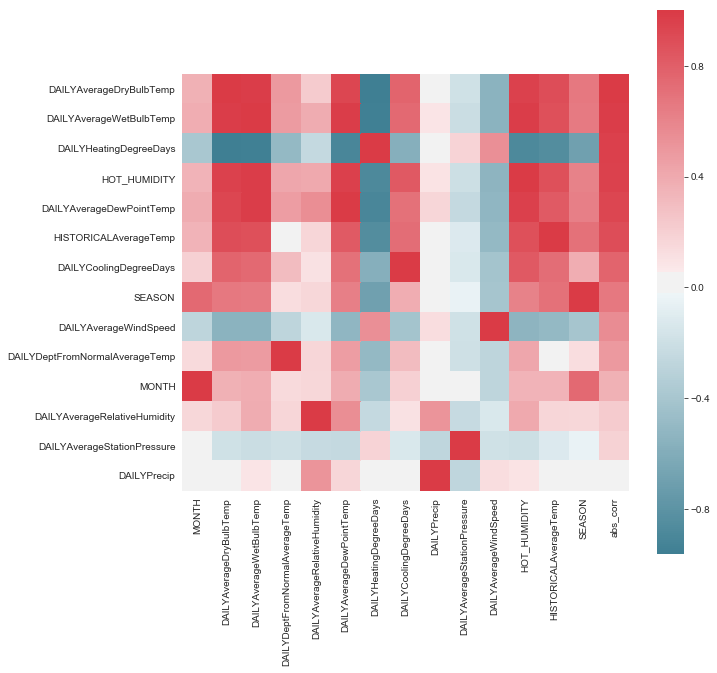

In [43]:
# sort corr map by Daily Precipitation

corrmat = nyc_daily.corr()
corrmat["abs_corr"] = abs(corrmat['DAILYAverageDryBulbTemp'])
corrmat = corrmat.sort_values("abs_corr", ascending=False)
corrmat
plt.figure(figsize=(10,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corrmat, square=True, cmap=cmap)
plt.show()

## Build the Models

Because we are trying to predict temperature, we should only use features that don't reference the actual temperature. So we will use the Historical AVG temp, the Season, the AVG Wind Speed and the Humidity

In [46]:
from sklearn import linear_model

# to split a training and test sample
from sklearn.model_selection import train_test_split

# Instantiate and fit our model.
Y = nyc_daily['DAILYAverageDryBulbTemp'].values.reshape(-1, 1)
X = nyc_daily[['HISTORICALAverageTemp', 'SEASON', 'DAILYAverageWindSpeed', 'DAILYAverageRelativeHumidity']]
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0)

regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(x_train, y_train))


Coefficients: 
 [[ 0.89767269  0.74097988 -0.99385671  0.06032797]]

Intercept: 
 [6.0569389]

R-squared:
0.8248580514855166


In [53]:
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)
y_pred = regr.predict(x_train)

from sklearn.metrics import mean_squared_error

print("Linear Train RMSE: %.3f" % mean_squared_error(y_train, y_pred)** 0.5)

Linear Train RMSE: 7.400


In [54]:
regr = linear_model.LinearRegression()
regr.fit(x_test, y_test)
y_pred = regr.predict(x_test)

from sklearn.metrics import mean_squared_error

print("Linear Test RMSE: %.3f" % mean_squared_error(y_test, y_pred)** 0.5)

Linear Test RMSE: 7.334


In [56]:
from sklearn import neighbors

# Build model using duration AND loudness instead of just \n",
# loudness in the example:
knn = neighbors.KNeighborsRegressor(n_neighbors=10)
knn.fit(x_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=10, p=2,
          weights='uniform')

In [57]:
# Build same model but this time weighted by (inverse of) distance 
knn_w = neighbors.KNeighborsRegressor(n_neighbors=10, weights='distance')
knn_w.fit(x_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=10, p=2,
          weights='distance')

In [49]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(knn, X, Y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score_w = cross_val_score(knn_w, X, Y, cv=5)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

Unweighted Accuracy: 0.80 (+/- 0.09)
Weighted Accuracy: 0.80 (+/- 0.10)


In [59]:
y_pred = knn.predict(x_test)

from sklearn.metrics import mean_squared_error

print("KNN Weighted Test RMSE: %.3f" % mean_squared_error(y_test, y_pred)** 0.5)

KNN Weighted Test RMSE: 7.449


In [58]:
y_pred = knn_w.predict(x_test)

from sklearn.metrics import mean_squared_error

print("KNN Weighted Test RMSE: %.3f" % mean_squared_error(y_test, y_pred)** 0.5)

KNN Weighted Test RMSE: 7.446


## Conclusion

Both models seem to perform pretty similarly, with the linear model performing slightly better. Fortunately it also seems like neither model is overfitting as both work on the test set just as well as the training set.